In [14]:
import math
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as dist
from scipy.optimize import minimize
from scipy.stats import norm

'''Surrogate Model Init and its Functions'''

class SurrogateModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SurrogateModel, self).__init__(train_x, train_y, likelihood)
        self.mean = gpytorch.means.ConstantMean()
        # Use ScaleKernel() to introduce variance hyperparameter
        self.covar = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean = self.mean(x)
        covar = self.covar(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

def train(model, train_x, train_y, training_iter, lr=0.001):
    model.train()  # Set the surrogate into training mode
    model.likelihood.train()

    # Initialize Adam to optimize variance and lengthscale of RBF kernel
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Outputs (size of train_x) number of multivariate distributions
        output = model(train_x)
        # Measures how well the GP fits the observed data
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

def predict(model, xaxis):
    """
    Make predictions with the trained GP model at new points.
    
    :param model: The trained Gaussian Process model.
    :param xaxis: Tensor of input points at which to make predictions.
    :return: mean and standard deviation of the GP at the given points.
    """
    model.eval()  # Set the model in evaluation mode
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Make predictions
        observed_pred = model(xaxis)
        mean = observed_pred.mean
        stddev = observed_pred.stddev
    return mean, stddev

'''Acquisition Functions'''

def ucb(model, xaxis, train_y, epsilon):
    mean, stdev = predict(model, xaxis)
    ucb_value = mean + epsilon * stdev
    return xaxis[torch.argmax(ucb_value)]

def poi(model, xaxis, train_y, epsilon):
    best_value = torch.max(train_y)
    mean, stdev = predict(model, xaxis)
    z = (mean - best_value - epsilon) / (stdev + 1e-9)
    PI = dist.Normal(0, 1).cdf(z)
    return xaxis[torch.argmax(PI)]

def ei(model, xaxis, train_y, epsilon):
    best_value = torch.max(train_y)
    mean, stdev = predict(model, xaxis)
    z = (mean - best_value - epsilon) / (stdev + 1e-9)  # Avoid division by zero
    normal = dist.Normal(0, 1)
    expected_improvement = (mean - best_value - epsilon) * normal.cdf(z) + stdev * normal.log_prob(z).exp()
    return xaxis[torch.argmax(expected_improvement)]

'''Different Bayesian Optimization Functions'''

def bayesian_optimization(model, xaxis, train_x, train_y, acquisition_function, epsilon, n_iter):
    """
    Perform Bayesian optimization with duplicate point avoidance.
    """
    min_dist = 1e-3  # Minimum distance threshold to consider points distinct

    for iteration in range(n_iter):
        # Select next sample using the chosen acquisition function
        next_sample = acquisition_function(model, xaxis, train_y, epsilon)
        
        # Ensure next_sample is a scalar value
        if next_sample.dim() > 0:
            next_sample = next_sample.item()
        next_sample = torch.tensor(next_sample, dtype=train_x.dtype)

        # Check if next_sample is too close to any existing point in train_x
        while torch.any(torch.abs(train_x - next_sample) < min_dist):
            # If it's a duplicate, randomly select a new point from xaxis
            available_points = xaxis[~torch.any(torch.abs(xaxis.view(-1, 1) - train_x) < min_dist, dim=1)]
            if len(available_points) == 0:  # If no available points left
                print(f"Iteration {iteration+1}: No new points available. Stopping early.")
                return train_x, train_y
            next_sample = available_points[torch.randint(0, len(available_points), (1,))].item()
            next_sample = torch.tensor(next_sample, dtype=train_x.dtype)

        # Evaluate the objective function at the new point
        next_y = torch.sin(2 * next_sample) + torch.cos(5 * next_sample)  # Example objective function

        # Update training data
        train_x = torch.cat([train_x, torch.tensor([next_sample], dtype=train_x.dtype)])
        train_y = torch.cat([train_y, torch.tensor([next_y], dtype=train_y.dtype)])

        # Update model with new training data
        model.set_train_data(train_x, train_y, strict=False)

        # Retrain the model
        train(model, train_x, train_y, training_iter=50, lr=0.001)

        # Predict mean and stddev for plotting
        mean, stddev = predict(model, xaxis)

        # Plot results
        plt.plot(xaxis.numpy(), ground_truth.numpy(), 'k', label='Ground Truth')
        plt.plot(xaxis.numpy(), mean.numpy(), 'b', label='Predicted Mean')
        plt.fill_between(xaxis.numpy(), (mean + 1.96 * stddev).numpy(), 
                        (mean - 1.96 * stddev).numpy(), alpha=0.3, color='blue', 
                        label='Confidence Interval (95%)')
        plt.scatter(train_x.numpy(), train_y.numpy(), color='r', zorder=10, label='Training Data')
        plt.title(f'Bayesian Optimization Iteration: {iteration+1}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()
        
    return train_x, train_y

"""Optimizing Epsilon Section"""

def optimize_acquisition1(acquisition_function, xaxis, ground_truth, n_runs=100, 
                         epsilon_range=(0.01, 2.0), n_epsilons=10, n_iter=5, tolerance=0.05):
    """
    Optimize the epsilon value for an acquisition function based on proximity to the x-value of the global maximum.
    """
    # Find the x-value of the global maximum
    true_max_idx = torch.argmax(ground_truth)
    x_target = xaxis[true_max_idx]  # x-value where ground_truth is maximized
    true_max = ground_truth[true_max_idx]  # For reference, not optimization
    epsilon_values = np.linspace(epsilon_range[0], epsilon_range[1], n_epsilons)
    samples_to_target = np.zeros((n_epsilons, n_runs))  # Store number of samples needed
    
    for eps_idx, epsilon in enumerate(epsilon_values):
        print(f"Testing epsilon: {epsilon:.3f}")
        for run in range(n_runs):
            # Randomize initial points for each run
            rand_samples = torch.rand(2) * 3  # Two random points in [0, 3]
            train_x = rand_samples
            train_y = torch.sin(2 * train_x) + torch.cos(5 * train_x)

            # Initialize the model
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            likelihood.noise = torch.tensor(1e-4)
            model = SurrogateModel(train_x, train_y, likelihood)
            train(model, train_x, train_y, training_iter=50, lr=0.001)

            # BO loop (with duplicate avoidance)
            min_dist = 1e-3  # Minimum distance threshold to consider points distinct
            for iteration in range(n_iter):
                # Select next sample using the chosen acquisition function
                next_sample = acquisition_function(model, xaxis, train_y, epsilon)
                
                # Ensure next_sample is a scalar value
                if next_sample.dim() > 0:
                    next_sample = next_sample.item()
                next_sample = torch.tensor(next_sample, dtype=train_x.dtype)

                # Check for duplicates and define available_points in scope
                duplicate_found = torch.any(torch.abs(train_x - next_sample) < min_dist)
                if duplicate_found:
                    available_points = xaxis[~torch.any(torch.abs(xaxis.view(-1, 1) - train_x) < min_dist, dim=1)]
                    if len(available_points) == 0:  # If no available points left
                        print(f"Epsilon {epsilon:.3f}, Run {run+1}, Iteration {iteration+1}: No new points available.")
                        samples_to_target[eps_idx, run] = train_x.size(0) + 1  # Assign penalty
                        break
                    next_sample = available_points[torch.randint(0, len(available_points), (1,))].item()
                    next_sample = torch.tensor(next_sample, dtype=train_x.dtype)

                # Evaluate the objective function at the new point
                next_y = torch.sin(2 * next_sample) + torch.cos(5 * next_sample)

                # Update training data
                train_x = torch.cat([train_x, torch.tensor([next_sample], dtype=train_x.dtype)])
                train_y = torch.cat([train_y, torch.tensor([next_y], dtype=train_y.dtype)])
                model.set_train_data(train_x, train_y, strict=False)
                train(model, train_x, train_y, training_iter=50, lr=0.001)

                # Check if we've sampled close to x_target
                min_distance = torch.min(torch.abs(train_x - x_target))
                if min_distance <= tolerance:
                    samples_to_target[eps_idx, run] = train_x.size(0)  # Total samples taken
                    break
                elif iteration == n_iter - 1:
                    # If max iterations reached without getting close, assign a high value
                    samples_to_target[eps_idx, run] = train_x.size(0) + 1  # Penalty

        # Calculate average samples for this epsilon
        avg_samples = np.mean(samples_to_target[eps_idx])
        print(f"Epsilon {epsilon:.3f} - Avg samples to x_target: {avg_samples:.2f}")

    # Find the epsilon with the minimum average samples
    avg_samples_per_epsilon = np.mean(samples_to_target, axis=1)
    best_epsilon_idx = np.argmin(avg_samples_per_epsilon)
    best_epsilon = epsilon_values[best_epsilon_idx]
    best_avg_samples = avg_samples_per_epsilon[best_epsilon_idx]

    print(f"\nOptimal epsilon: {best_epsilon:.3f}")
    print(f"Average samples to reach x_target ({x_target:.3f}): {best_avg_samples:.2f}")

    # Plotting results
    plt.plot(epsilon_values, avg_samples_per_epsilon, 'b-', label='Avg Samples to x_target')
    plt.axvline(best_epsilon, color='r', linestyle='--', label=f'Optimal Epsilon: {best_epsilon:.3f}')
    plt.xlabel('Epsilon')
    plt.ylabel('Average Samples to Reach x of Maximum')
    plt.title(f'Epsilon Optimization for Finding x = {x_target:.3f}')
    plt.legend()
    plt.show()

    return best_epsilon, avg_samples_per_epsilon

"""Comparing Acquisition Section"""

def compare_acquisition_functions(acq_functions_with_epsilons, xaxis, ground_truth, n_runs=1000, n_iter=5):
    """
    Compare acquisition functions by averaging the maximum y-values picked up to each evaluation step.
    """
    results = {}
    for name, (acq_func, epsilon) in acq_functions_with_epsilons.items():
        print(f"Running BO {n_runs} times for {name} with epsilon={epsilon:.3f}")
        y_values = np.zeros((n_runs, n_iter + 2))  # 2 initial + n_iter
        max_y_values = np.zeros((n_runs, n_iter + 2))  # To track max y so far
        
        for run in range(n_runs):
            # Random initial points
            rand_samples = torch.rand(2) * 3
            train_x = rand_samples
            train_y = torch.sin(2 * train_x) + torch.cos(5 * train_x)
            
            # Record y-values for initial points
            y_values[run, 0] = train_y[0].item()  # 1st point
            y_values[run, 1] = train_y[1].item()  # 2nd point
            max_y_values[run, 0] = y_values[run, 0]
            max_y_values[run, 1] = max(y_values[run, 0], y_values[run, 1])

            if y_values[run, 1] > y_values[run, 0]:  # If 2nd random point is better
                max_y_values[run, 0] = max_y_values[run, 1]

            # Initialize model
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            likelihood.noise = torch.tensor(1e-4)
            model = SurrogateModel(train_x, train_y, likelihood)
            train(model, train_x, train_y, training_iter=50, lr=0.1)
            
            # BO loop (with duplicate avoidance)
            min_dist = 1e-3  # Minimum distance threshold to consider points distinct
            for i in range(n_iter):
                # Select next sample using the chosen acquisition function
                next_sample = acq_func(model, xaxis, train_y, epsilon)
                
                # Ensure next_sample is a scalar value
                if next_sample.dim() > 0:
                    next_sample = next_sample.item()
                next_sample = torch.tensor(next_sample, dtype=train_x.dtype)

                # Check if next_sample is too close to any existing point in train_x
                while torch.any(torch.abs(train_x - next_sample) < min_dist):
                    # If it's a duplicate, randomly select a new point from xaxis
                    available_points = xaxis[~torch.any(torch.abs(xaxis.view(-1, 1) - train_x) < min_dist, dim=1)]
                    if len(available_points) == 0:  # If no available points left
                        print(f"Run {run+1}, Iteration {i+1}: No new points available. Stopping early.")
                        break
                    next_sample = available_points[torch.randint(0, len(available_points), (1,))].item()
                    next_sample = torch.tensor(next_sample, dtype=train_x.dtype)

                # Evaluate the objective function at the new point
                next_y = torch.sin(2 * next_sample) + torch.cos(5 * next_sample)
                
                # Update training data
                train_x = torch.cat([train_x, torch.tensor([next_sample], dtype=train_x.dtype)])
                train_y = torch.cat([train_y, torch.tensor([next_y], dtype=train_y.dtype)])
                
                # Update model with new training data
                model.set_train_data(train_x, train_y, strict=False)
                train(model, train_x, train_y, training_iter=50, lr=0.1)
                
                # Record the y-value picked
                y_values[run, i + 2] = next_y.item()
                # Update max y so far
                max_y_values[run, i + 2] = max(max_y_values[run, i + 1], y_values[run, i + 2])
        
        results[name] = max_y_values  # Store the max y values instead of raw y values
    
    # Plotting
    plt.figure(figsize=(10, 6))
    n_evaluations = np.arange(1, n_iter + 3)  # 1 to 7
    true_max = torch.max(ground_truth).item()
    
    for name, max_y_values in results.items():
        avg_max_y_values = np.mean(max_y_values, axis=0)  # Average max y at each step
        plt.plot(n_evaluations, avg_max_y_values, label=name, marker='o')
    
    plt.axhline(y=true_max, color='k', linestyle='--', label=f'True Max ({true_max:.3f})')
    plt.xlabel('Evaluation Number')
    plt.ylabel('Average Maximum Y-Value Picked So Far')
    plt.title(f'Comparison of Acquisition Functions: Average Max Y-Value per Evaluation ({n_runs} Runs)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return results

/var/folders/gq/ysxmb7xx7d7_3hpwg1pcnx800000gn/T/ipykernel_81612/1172393582.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_sample = torch.tensor(next_sample, dtype=train_x.dtype)


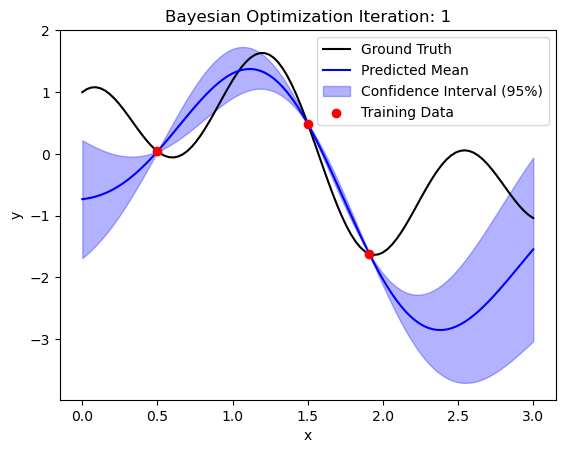

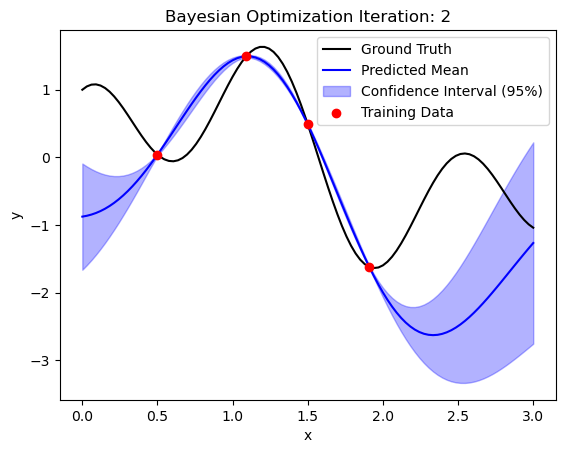

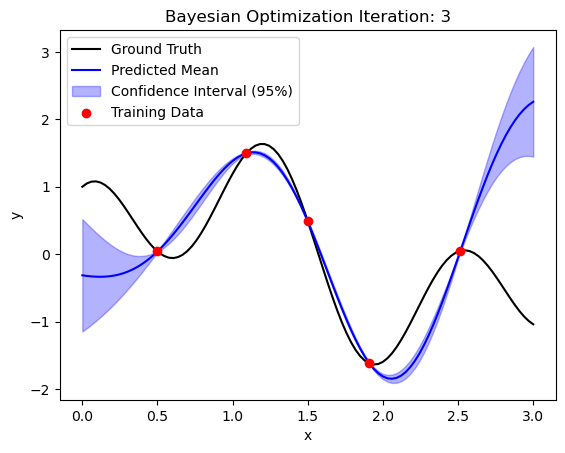

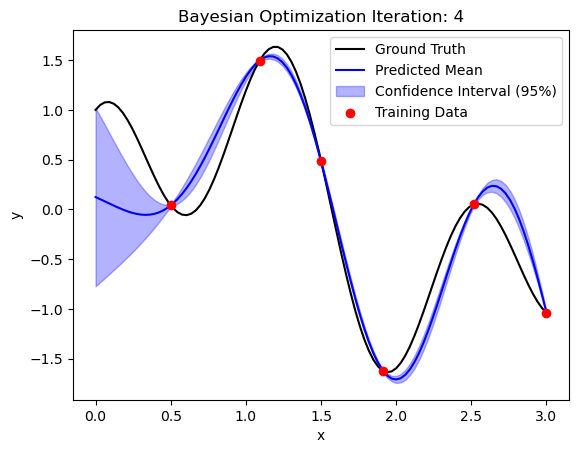

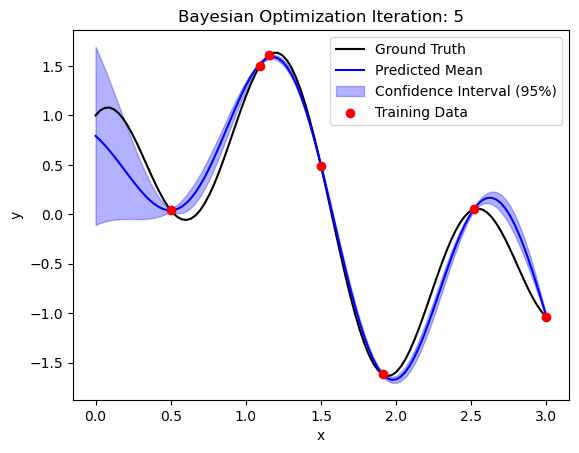

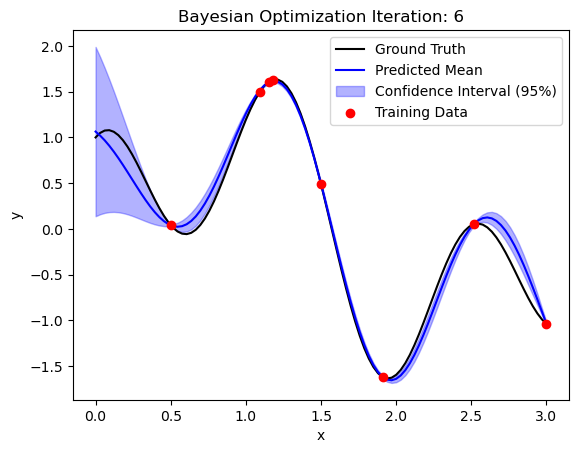

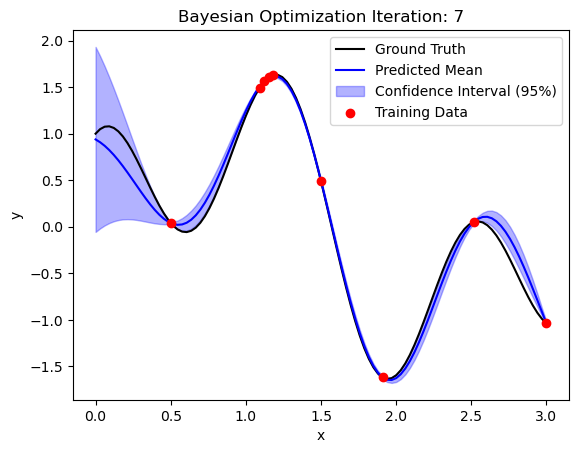

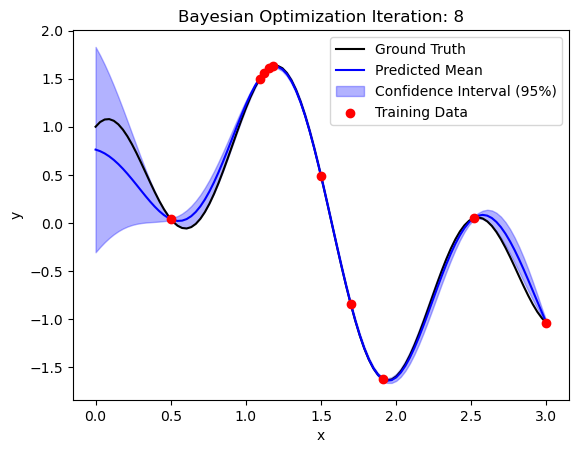

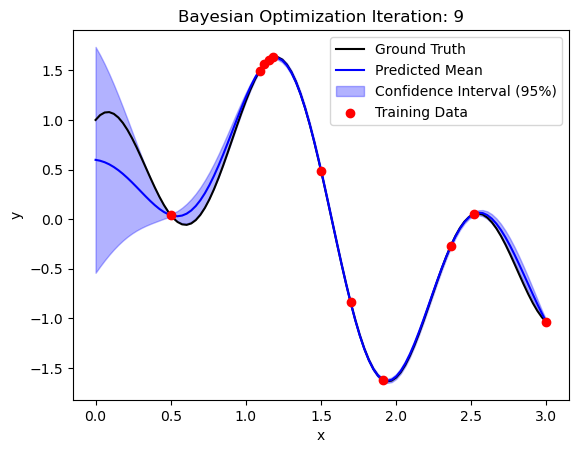

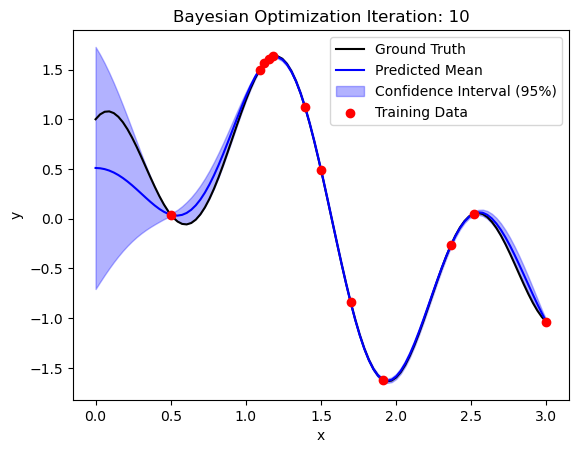

In [16]:
# Example usage
if __name__ == "__main__":
    # Define the domain and ground truth
    xaxis = torch.linspace(0, 3, 100)
    ground_truth = torch.sin(2 * xaxis) + torch.cos(5 * xaxis)

    # Initial points for bayesian_optimization
    train_x = torch.tensor([0.5, 1.5])
    train_y = torch.sin(2 * train_x) + torch.cos(5 * train_x)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise = torch.tensor(1e-4)
    model = SurrogateModel(train_x, train_y, likelihood)
    train(model, train_x, train_y, training_iter=50, lr=0.001)

    # Run bayesian_optimization
    train_x, train_y = bayesian_optimization(model, xaxis, train_x, train_y, ucb, 0.294, 10)

Testing epsilon: 0.010


/var/folders/gq/ysxmb7xx7d7_3hpwg1pcnx800000gn/T/ipykernel_81612/1172393582.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_sample = torch.tensor(next_sample, dtype=train_x.dtype)


Epsilon 0.010 - Avg samples to x_target: 6.60
Testing epsilon: 0.020
Epsilon 0.020 - Avg samples to x_target: 6.50
Testing epsilon: 0.030
Epsilon 0.030 - Avg samples to x_target: 6.80
Testing epsilon: 0.040
Epsilon 0.040 - Avg samples to x_target: 6.50
Testing epsilon: 0.050
Epsilon 0.050 - Avg samples to x_target: 6.80
Testing epsilon: 0.060
Epsilon 0.060 - Avg samples to x_target: 6.00
Testing epsilon: 0.070
Epsilon 0.070 - Avg samples to x_target: 5.90
Testing epsilon: 0.080
Epsilon 0.080 - Avg samples to x_target: 7.30
Testing epsilon: 0.090
Epsilon 0.090 - Avg samples to x_target: 6.90
Testing epsilon: 0.100
Epsilon 0.100 - Avg samples to x_target: 6.70

Optimal epsilon: 0.070
Average samples to reach x_target (1.212): 5.90


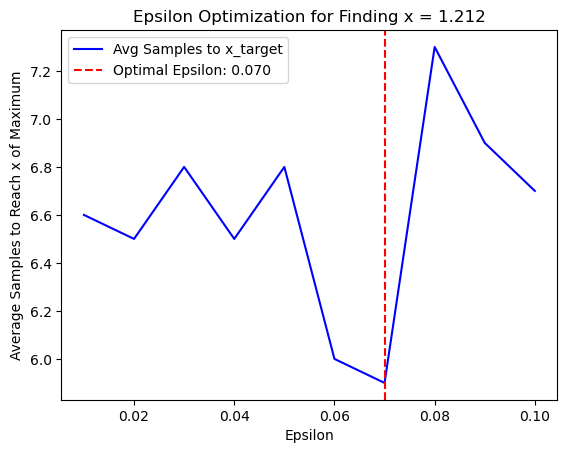

In [19]:
# Run optimize_acquisition1
best_epsilon, stats = optimize_acquisition1(ei, xaxis, ground_truth, n_runs=10, 
                                               epsilon_range=(0.01, .1), n_epsilons=10, 
                                               n_iter=5, tolerance=0.05)


Testing epsilon: 0.010


/var/folders/gq/ysxmb7xx7d7_3hpwg1pcnx800000gn/T/ipykernel_81612/1172393582.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_sample = torch.tensor(next_sample, dtype=train_x.dtype)


Epsilon 0.010 - Avg samples to x_target: 7.60
Testing epsilon: 0.020
Epsilon 0.020 - Avg samples to x_target: 7.70
Testing epsilon: 0.030
Epsilon 0.030 - Avg samples to x_target: 5.40
Testing epsilon: 0.040
Epsilon 0.040 - Avg samples to x_target: 6.90
Testing epsilon: 0.050
Epsilon 0.050 - Avg samples to x_target: 6.60
Testing epsilon: 0.060
Epsilon 0.060 - Avg samples to x_target: 6.80
Testing epsilon: 0.070
Epsilon 0.070 - Avg samples to x_target: 6.90
Testing epsilon: 0.080
Epsilon 0.080 - Avg samples to x_target: 6.00
Testing epsilon: 0.090
Epsilon 0.090 - Avg samples to x_target: 7.00
Testing epsilon: 0.100
Epsilon 0.100 - Avg samples to x_target: 7.90

Optimal epsilon: 0.030
Average samples to reach x_target (1.212): 5.40


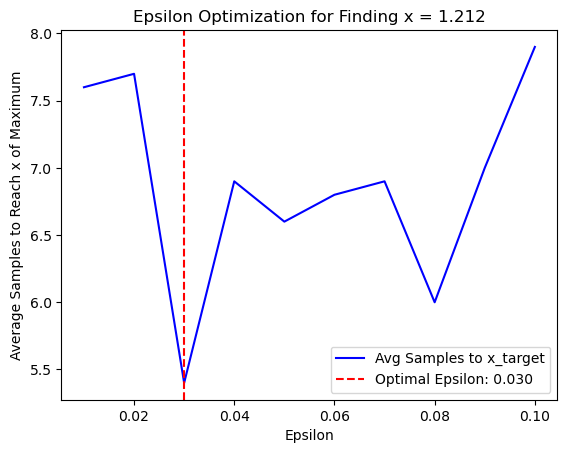

In [20]:
# Run optimize_acquisition1
best_epsilon, stats = optimize_acquisition1(poi, xaxis, ground_truth, n_runs=10, 
                                               epsilon_range=(0.01, .1), n_epsilons=10, 
                                               n_iter=5, tolerance=0.015)

Testing epsilon: 0.100


/var/folders/gq/ysxmb7xx7d7_3hpwg1pcnx800000gn/T/ipykernel_81612/1172393582.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_sample = torch.tensor(next_sample, dtype=train_x.dtype)


Epsilon 0.100 - Avg samples to x_target: 7.40
Testing epsilon: 0.144
Epsilon 0.144 - Avg samples to x_target: 7.30
Testing epsilon: 0.189
Epsilon 0.189 - Avg samples to x_target: 7.30
Testing epsilon: 0.233
Epsilon 0.233 - Avg samples to x_target: 6.50
Testing epsilon: 0.278
Epsilon 0.278 - Avg samples to x_target: 7.60
Testing epsilon: 0.322
Epsilon 0.322 - Avg samples to x_target: 7.70
Testing epsilon: 0.367
Epsilon 0.367 - Avg samples to x_target: 7.70
Testing epsilon: 0.411
Epsilon 0.411 - Avg samples to x_target: 7.70
Testing epsilon: 0.456
Epsilon 0.456 - Avg samples to x_target: 7.00
Testing epsilon: 0.500
Epsilon 0.500 - Avg samples to x_target: 7.70

Optimal epsilon: 0.233
Average samples to reach x_target (1.212): 6.50


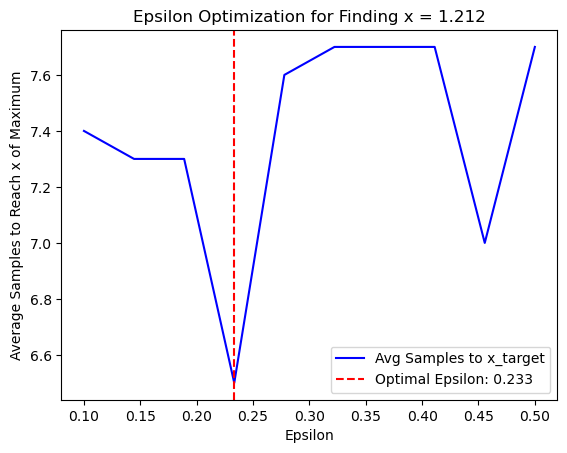

In [22]:
# Run optimize_acquisition1
best_epsilon, stats = optimize_acquisition1(ucb, xaxis, ground_truth, n_runs=10, 
                                               epsilon_range=(0.1,.5), n_epsilons=10, 
                                               n_iter=5, tolerance=0.015)

Running BO 10 times for UCB with epsilon=0.233


/var/folders/gq/ysxmb7xx7d7_3hpwg1pcnx800000gn/T/ipykernel_81612/1172393582.py:273: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_sample = torch.tensor(next_sample, dtype=train_x.dtype)


Running BO 10 times for EI with epsilon=0.070
Running BO 10 times for POI with epsilon=0.030


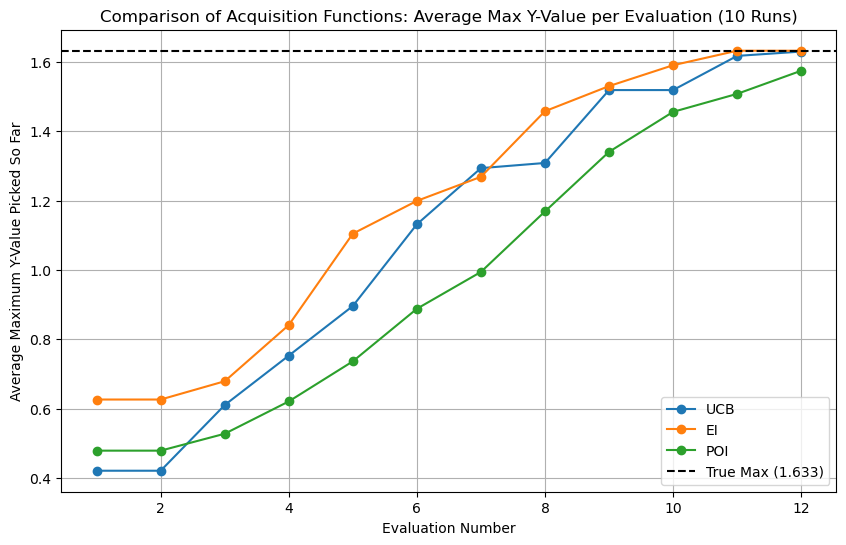

In [27]:
# Run compare_acquisition_functions
acq_functions_with_epsilons = {
        "UCB": (ucb, 0.233),
        "EI": (ei, 0.07),
        "POI": (poi, 0.03)
    }
results = compare_acquisition_functions(acq_functions_with_epsilons, xaxis, ground_truth, n_runs=10, n_iter=10)